# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def grow_tree(X, y, number_of_features, max_depth, min_samples_for_split, criterion, depth=0):
    """
    X: This is the input data (features)
    y: This is the target labels (classes)
    number_of_features: is the number of features to consider when looking for the best split. This is useful
                        in for example ensamble models or random forest. Using less features reduce overfitting, and can help speed up training.
    max_depth: is the maximum depth of the tree
    min_samples_for_split: is the minimum number of samples required to split an internal node.
    depth: is the current depth of the tree, needed for the recursion.
    """
    nbr_samples = len(X)
    nbr_features = len(X[0])
    nbr_of_unique_labels = np.unique(y)

    if (depth >= max_depth or len(nbr_of_unique_labels) == 1 or nbr_samples <= min_samples_for_split or homogeneous(y)):
        leaf_value = most_common_label(y)
        return Node(value=leaf_value)
    
    number_of_features = X.shape[1] if not number_of_features else min(X.shape[1], number_of_features)
    feat_idxs = np.random.choice(nbr_features, number_of_features, replace=False) # Väljer "nbr_features" stycken random indexes

    """
    Hittar bästa splitten genom att skicka in träningsdatan 'X', samt träningslabels 'y', nbr_features stycken random feature indexes.
    X: Feature input data
    y: The target labels 
    feat_idxs: The randomly chosen feature indexes 
    """
    best_feature, best_threshold = bestSplit(X, y, feat_idxs, criterion) 

    left_idxs = np.where(X[:, best_feature] <= best_threshold)[0]
    right_idxs = np.where(X[:, best_feature] > best_threshold)[0]
    
    left = grow_tree(X[left_idxs, :], y[left_idxs], number_of_features, max_depth, min_samples_for_split, criterion, depth + 1)
    right = grow_tree(X[right_idxs, :], y[right_idxs], number_of_features, max_depth, min_samples_for_split, criterion, depth + 1)
    return Node(best_feature, best_threshold, left, right)


data_wine = pd.read_csv("wine.csv").to_numpy()
data_wine = data_wine[1:]


# TODO: Set up the data and split it into train and test-sets.
X = data_wine[:, :-1]
y = data_wine[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
number_of_features = X.shape[1]
root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='gini')
my_predictions = np.array([traverse_tree(x, root) for x in X_test])

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [133]:
def homogeneous(y, threshold=0.9):
    most_common = most_common_label(y)
    count = np.sum(y == most_common)
    return count / len(y) >= threshold


### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [134]:
def information_gain(y, X_column, thr, criterion=None):
    
    left_idx = np.where(X_column <= thr)[0]
    right_idx = np.where(X_column > thr)[0]

    left_side_idxs_len, right_side_idxs_len = len(left_idx), len(right_idx)

    if left_side_idxs_len == 0 or right_side_idxs_len == 0:
        return 0
    
    n = len(y)
    parent_impurity, left_side_impurity, right_side_impurity = None, None, None

    if criterion.lower() == 'entropy':
        parent_impurity = entropy(y)
        left_side_impurity = entropy(y[left_idx])
        right_side_impurity = entropy(y[right_idx])
    elif criterion.lower() == 'ginisqrt':
        parent_impurity = giniSqrt(y)
        left_side_impurity = giniSqrt(y[left_idx])
        right_side_impurity = giniSqrt(y[right_idx])
    else:
        parent_impurity = gini(y)
        left_side_impurity = gini(y[left_idx])
        right_side_impurity = gini(y[right_idx])
    
    child_impurity = ((left_side_idxs_len / n) * left_side_impurity) + ((right_side_idxs_len / n) * right_side_impurity)
    
    information_gain = parent_impurity - child_impurity
    return information_gain 

def gini(y):
    hist = create_histogram(y)
    ps = hist / len(y)
    return 1 - np.sum(ps ** 2)

def giniSqrt(y):
    return np.sqrt(gini(y))

def entropy(y):
    hist = create_histogram(y)
        
    ps = hist / len(y)
    return -np.sum([p * np.log(p) for p in ps if p>0])

def create_histogram(y):
    cnt = {}
    for yi in y:
        if yi in cnt:
            cnt[yi] += 1
        else:
            cnt[yi] = 1

    unique_labels = sorted(cnt.keys())

    hist = []
    for label in unique_labels:
        if label in cnt:
            hist.append(cnt[label])
        else: 
            hist.append(0)

    return np.array(hist)

def most_common_label(y):
    counter = {}
    for label in y:
        if label in counter:
            counter[label] += 1
        else:
            counter[label] = 1

    mx = float('-inf')
    ky = 0
    for key, val in counter.items():
        if val > mx:
            mx = val
            ky = key

    return ky

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [135]:
def bestSplit(X, y, feat_idxs, criterion):
    best_gain = -1
    split_idx, split_threshold = None, None

    for feat_idx in feat_idxs:
        X_column = X[:, feat_idx]
        thresholds = np.unique(X_column)

        for thr in thresholds:
            gain = information_gain(y, X_column, thr, criterion)

            if gain > best_gain:
                best_gain = gain
                split_idx = feat_idx
                split_threshold = thr

    return split_idx, split_threshold


### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [136]:
def traverse_tree(x, node):
    if node.value is not None:
        return node.value
    
    if x[node.feature] <= node.threshold:
        return traverse_tree(x, node.left)
    return traverse_tree(x, node.right)

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

In [137]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [138]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

#accuracy_score(y_true, y_pred)

### 6) Dataset 1: Wine

[0.8055555555555556, 0.8888888888888888, 0.9444444444444444, 0.8888888888888888, 0.9166666666666666]
[0.9444444444444444, 0.8611111111111112, 0.9722222222222222, 0.8888888888888888, 0.9444444444444444]


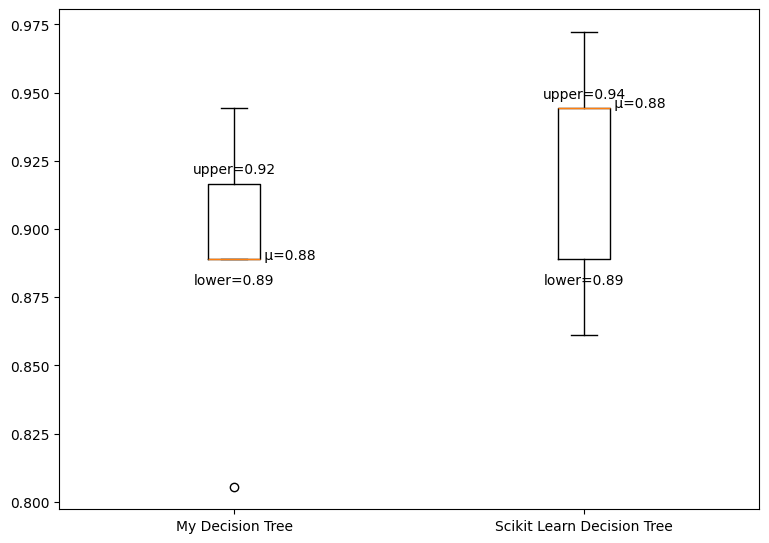

In [139]:
data_wine = pd.read_csv("wine.csv").to_numpy()
data_wine = data_wine[1:]


# TODO: Set up the data and split it into train and test-sets.
X = data_wine[:, :-1]
y = data_wine[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
number_of_features = X.shape[1]
root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='gini')
my_predictions = np.array([traverse_tree(x, root) for x in X_test])


# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
scikit_clf = DecisionTreeClassifier(criterion='gini')
scikit_clf.fit(X_train, y_train)
scikit_predictions = scikit_clf.predict(X_test)


# TODO: Do the above at least 5 times
# NOTE: Use loops here!
my_accuracies = []
sciKit_accuracies = []
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    number_of_features = X.shape[1]
    root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='gini')
    my_predictions = np.array([traverse_tree(x, root) for x in X_test])
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_accuracies.append(my_accuracy)

    scikit_clf = DecisionTreeClassifier(criterion='gini')
    scikit_clf.fit(X_train, y_train)
    scikit_predictions = scikit_clf.predict(X_test)
    sciKit_accuracy = accuracy_score(y_test, scikit_predictions)
    sciKit_accuracies.append(sciKit_accuracy)

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
boxplotData = [my_accuracies, sciKit_accuracies]
print(my_accuracies)
print(sciKit_accuracies)

fig = plt.figure(figsize =(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
labels = ['My Decision Tree', 'Scikit Learn Decision Tree']
bp = ax.boxplot(boxplotData, labels=labels)

boxplotDataNP = np.array(boxplotData)
m1 = boxplotDataNP.mean(axis=0)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}'.format(m1[i])
    ax.annotate(text, xy=(x, y))

for i, box in enumerate(bp['boxes']):
    upper_quartile = box.get_ydata()[2]
    ax.annotate(f'upper={upper_quartile:.2f}', xy=(i + 1, upper_quartile), xytext=(0, 5),
                textcoords='offset points', ha='center', va='bottom')

    lower_quartile = box.get_ydata()[1]
    ax.annotate(f'lower={lower_quartile:.2f}', xy=(i + 1, lower_quartile), xytext=(0, -10),
                textcoords='offset points', ha='center', va='top')

plt.show()


### 7) Dataset 2: Heart Disease

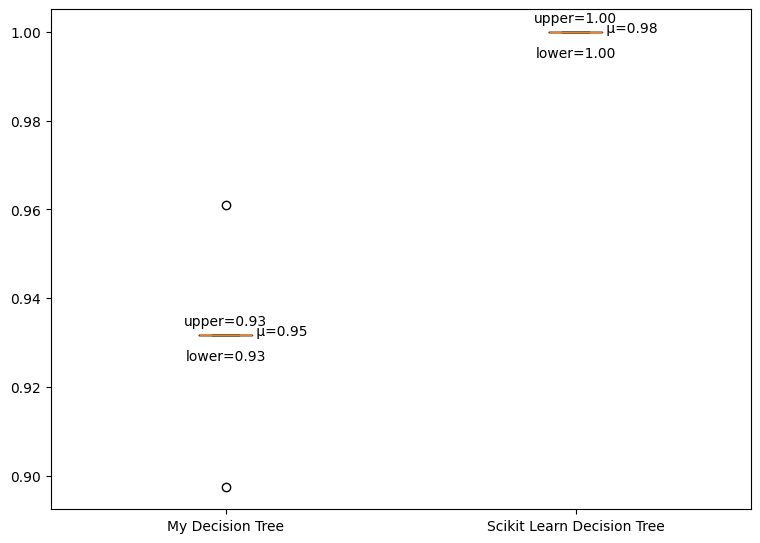

In [140]:
data_heart = pd.read_csv("heart.csv").to_numpy()

# TODO: Set up the data and split it into train and test-sets.
X = data_heart[:, :-1]
y = data_heart[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
number_of_features = X.shape[1]
root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
my_predictions = np.array([traverse_tree(x, root) for x in X_test])


# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
scikit_clf = DecisionTreeClassifier(criterion='entropy')
scikit_clf.fit(X_train, y_train)
scikit_predictions = scikit_clf.predict(X_test)

# TODO: Do the above at least 5 times
# NOTE: Use loops here!

my_accuracies = []
sciKit_accuracies = []
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    number_of_features = X.shape[1]
    root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
    my_predictions = np.array([traverse_tree(x, root) for x in X_test])
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_accuracies.append(my_accuracy)

    scikit_clf = DecisionTreeClassifier(criterion='entropy')
    scikit_clf.fit(X_train, y_train)
    scikit_predictions = scikit_clf.predict(X_test)
    sciKit_accuracy = accuracy_score(y_test, scikit_predictions)
    sciKit_accuracies.append(sciKit_accuracy)

# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
boxplotData = [my_accuracies, sciKit_accuracies]
fig = plt.figure(figsize =(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
labels = ['My Decision Tree', 'Scikit Learn Decision Tree']
bp = ax.boxplot(boxplotData, labels=labels)

boxplotDataNP = np.array(boxplotData)
m1 = boxplotDataNP.mean(axis=0)
for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}'.format(m1[i])
    ax.annotate(text, xy=(x, y))

for i, box in enumerate(bp['boxes']):
    upper_quartile = box.get_ydata()[2]
    ax.annotate(f'upper={upper_quartile:.2f}', xy=(i + 1, upper_quartile), xytext=(0, 5),
                textcoords='offset points', ha='center', va='bottom')

    lower_quartile = box.get_ydata()[1]
    ax.annotate(f'lower={lower_quartile:.2f}', xy=(i + 1, lower_quartile), xytext=(0, -10),
                textcoords='offset points', ha='center', va='top')

plt.show()

### 8) Dataset 3: Car

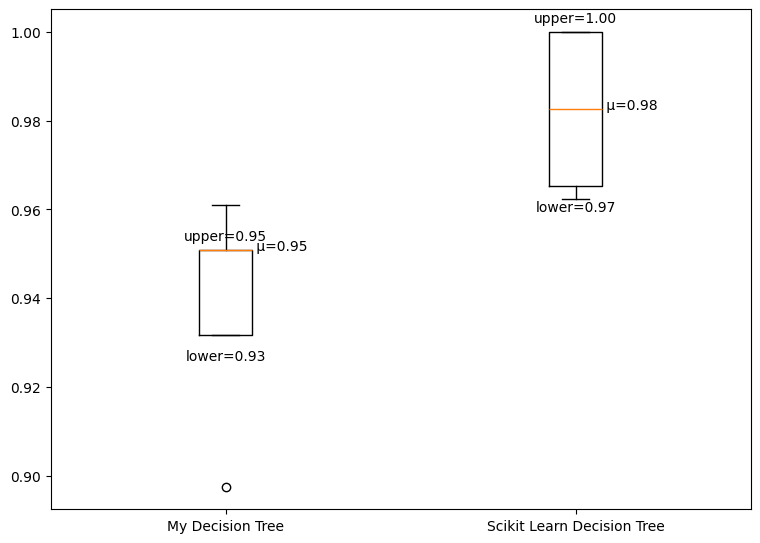

In [141]:
from sklearn.preprocessing import OneHotEncoder

data_car = pd.read_csv("car.csv").to_numpy()


# TODO: Set up the data and split it into train and test-sets.
X = data_car[:, :-1]
y = data_car[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


# TODO: Train and test your implemented tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
number_of_features = X.shape[1]
root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
my_predictions = np.array([traverse_tree(x, root) for x in X_test])

# TODO: Train and test scikit learns tree model.
# NOTE: Use the same train/test split for your tree model and the scikit learn model
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train)
X_test_ohe = encoder.transform(X_test)
scikit_clf = DecisionTreeClassifier(criterion='entropy')
scikit_clf.fit(X_train_ohe, y_train)
scikit_predictions = scikit_clf.predict(X_test_ohe)


# TODO: Do the above at least 5 times
# NOTE: Use loops here!
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    number_of_features = X.shape[1]
    root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
    my_predictions = np.array([traverse_tree(x, root) for x in X_test])
    my_accuracy = accuracy_score(y_test, my_predictions)
    my_accuracies.append(my_accuracy)

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_train_ohe = encoder.fit_transform(X_train)
    X_test_ohe = encoder.transform(X_test)

    scikit_clf = DecisionTreeClassifier(criterion='entropy')
    scikit_clf.fit(X_train_ohe, y_train)
    scikit_predictions = scikit_clf.predict(X_test_ohe)
    sciKit_accuracy = accuracy_score(y_test, scikit_predictions)
    sciKit_accuracies.append(sciKit_accuracy)


# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
boxplotData = [my_accuracies, sciKit_accuracies]
fig = plt.figure(figsize =(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
labels = ['My Decision Tree', 'Scikit Learn Decision Tree']
bp = ax.boxplot(boxplotData, labels=labels)

for i, line in enumerate(bp['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}'.format(m1[i])
    ax.annotate(text, xy=(x, y))

for i, box in enumerate(bp['boxes']):
    upper_quartile = box.get_ydata()[2]
    ax.annotate(f'upper={upper_quartile:.2f}', xy=(i + 1, upper_quartile), xytext=(0, 5),
                textcoords='offset points', ha='center', va='bottom')

    lower_quartile = box.get_ydata()[1]
    ax.annotate(f'lower={lower_quartile:.2f}', xy=(i + 1, lower_quartile), xytext=(0, -10),
                textcoords='offset points', ha='center', va='top')


plt.show()



### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

0.8611111111111112
0.9444444444444444


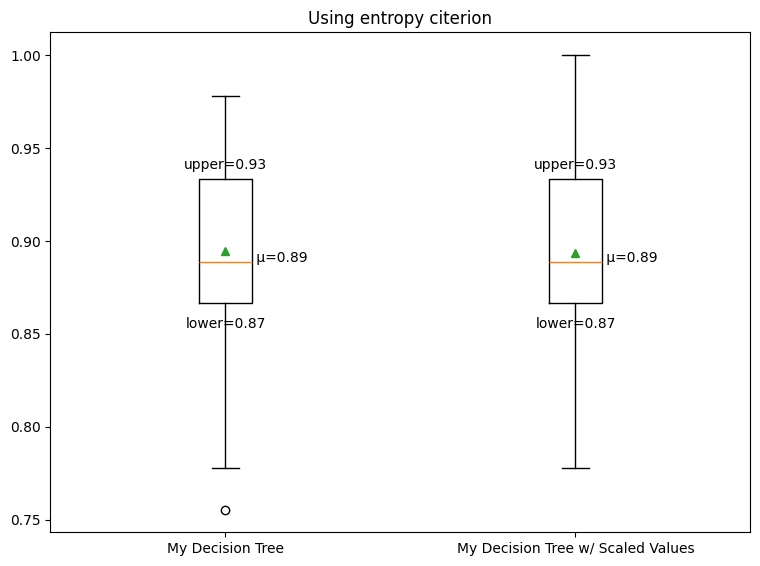

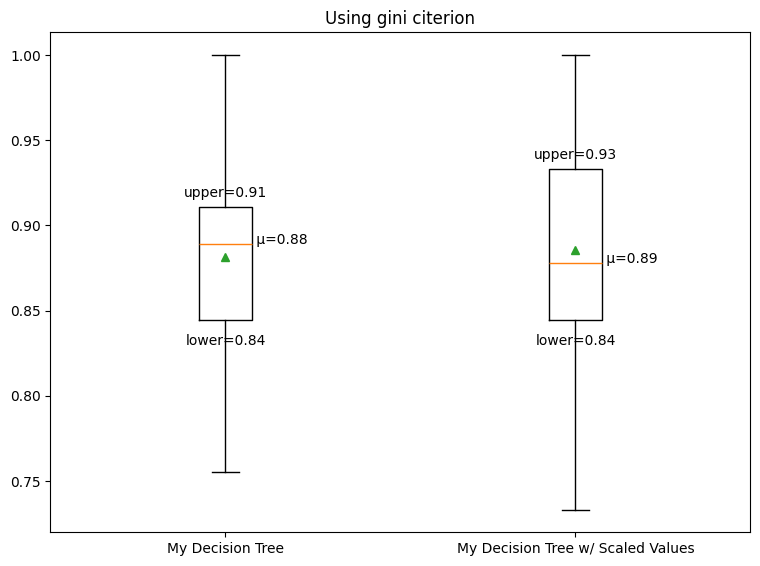

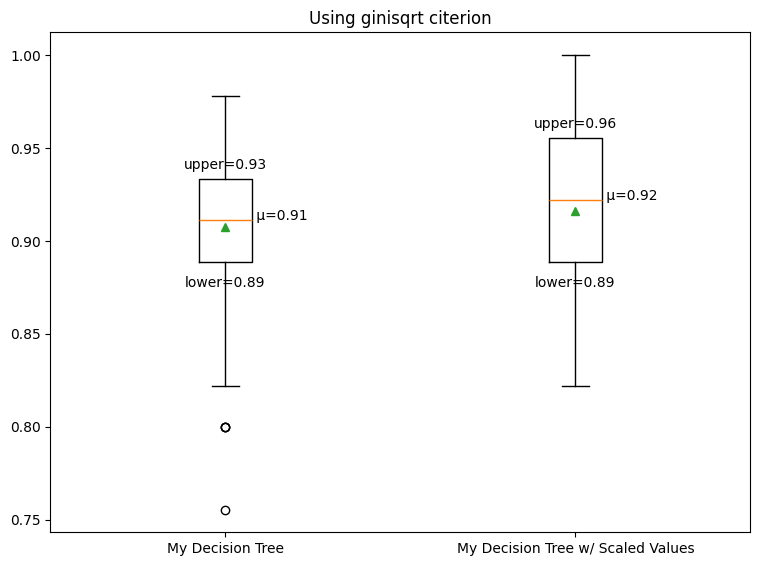

In [142]:
from sklearn import preprocessing

# TODO: Use the wine dataset from above and scale its features and labels between 0 and 1

data_wine = pd.read_csv("wine.csv").to_numpy()
data_wine = data_wine[1:]

X = data_wine[:, :-1]
y = data_wine[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train_minmax = preprocessing.normalize(X_train)
X_test_minmax = preprocessing.normalize(X_test)


# TODO: Run the code from the dataset and compare the preprocessed vs non-preprocessed data.
# NOTE: You can copy most of the workflow from the dataset code above to save you some time.
# NOTE: Use the same train/test split for your tree model for both the preprocessed vs non-preprocessed data.
number_of_features = X.shape[1]
root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
my_predictions = np.array([traverse_tree(x, root) for x in X_test])
my_accuracy = accuracy_score(y_test, my_predictions)
print(my_accuracy)

number_of_features = X.shape[1]
root = grow_tree(X_train_minmax, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion='entropy')
my_predictions = np.array([traverse_tree(x, root) for x in X_test_minmax])
my_accuracy = accuracy_score(y_test, my_predictions)
print(my_accuracy)

# Parameter optimisation
X = data_wine[:, :-1]
y = data_wine[:, -1]

def parameter_optimization(max_number_of_features=None, max_depth=None, max_samples_for_split=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    max_accuracy = {}
    best_so_far = 0
    iteration = 0

    for i in reversed(range(1, max_number_of_features)):
        for j in range(max_depth):
            for k in range(max_samples_for_split):
                #print(f"Iteration {iteration};;;; max_number_of_features: {i}, max_depth: {j}, min_samples_for_split: {k}")
                iteration += 1
                root = grow_tree(X_train, y_train, i, j, k)
                my_predictions = np.array([traverse_tree(x, root) for x in X_test])
                my_accuracy = accuracy_score(y_test, my_predictions)
                if my_accuracy > best_so_far:
                    best_so_far = my_accuracy
                    print(f"Best accuracy so far: {best_so_far}, max_number_of_features: {i}, max_depth: {j}, min_samples_for_split: {k}")
                max_accuracy[my_accuracy] = [i, j, k]
    
    best = max(max_accuracy.keys())
    print(f"Best accuracy: {best}")
    print(f"Parameters for best accuracy: max_number_of_features: {max_accuracy[best][0]}, max_depth: {max_accuracy[best][1]}, min_samples_for_split: {max_accuracy[best][2]}")

#parameter_optimization(max_number_of_features=X.shape[1], max_depth=5, max_samples_for_split=7)


# TODO: Do the above at least 5 times
# NOTE: Use loops here!

boxPlotDataArrays = []
criterions = ['entropy', 'gini', 'ginisqrt']
for criteria in criterions:
    my_accuracies = []
    my_accuracies_scaled = []
    for _ in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
        X_train_minmax = preprocessing.normalize(X_train)
        X_test_minmax = preprocessing.normalize(X_test)

        number_of_features = X.shape[1]
        root = grow_tree(X_train, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion=criteria)
        my_predictions = np.array([traverse_tree(x, root) for x in X_test])
        my_accuracy = accuracy_score(y_test, my_predictions)
        my_accuracies.append(my_accuracy)

        number_of_features = X.shape[1]
        root = grow_tree(X_train_minmax, y_train, number_of_features, max_depth=10, min_samples_for_split=2, criterion=criteria)
        my_predictions_scaled = np.array([traverse_tree(x, root) for x in X_test_minmax])
        my_accuracy_scaled = accuracy_score(y_test, my_predictions_scaled)
        my_accuracies_scaled.append(my_accuracy_scaled)
    
    boxplotData = [my_accuracies, my_accuracies_scaled]
    boxPlotDataArrays.append(boxplotData)
    
# TODO: Plot the results with matplotlib (plt)
# NOTE: One plot with all results is enough
for i, bpd in enumerate(boxPlotDataArrays):
    fig = plt.figure(figsize =(7, 5))
    ax = fig.add_axes([0, 0, 1, 1])
    labels = ['My Decision Tree', 'My Decision Tree w/ Scaled Values']
    bp = ax.boxplot(bpd, labels=labels, showmeans=True)
    ax.set_title(f'Using {criterions[i]} citerion')
    m1 = np.mean(bpd, axis=1)
    for i, line in enumerate(bp['medians']):
        x, y = line.get_xydata()[1]
        text = ' μ={:.2f}'.format(m1[i])
        ax.annotate(text, xy=(x, y))

    for i, box in enumerate(bp['boxes']):
        upper_quartile = box.get_ydata()[2]
        ax.annotate(f'upper={upper_quartile:.2f}', xy=(i + 1, upper_quartile), xytext=(0, 5),
                    textcoords='offset points', ha='center', va='bottom')

        lower_quartile = box.get_ydata()[1]
        ax.annotate(f'lower={lower_quartile:.2f}', xy=(i + 1, lower_quartile), xytext=(0, -10),
                    textcoords='offset points', ha='center', va='top')

    plt.show()


# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is growing the tree indefinitely such a bad idea? The performance would increase would it not?

2) Beside preventing the tree from growing to large, what is the purpose of 'stopping criterias'?

3) What is the difference between **Information Entropy** and **Gini Impurity**?

4) What are some pros about using decision trees?

5) Did preprocessing the data help with performance when using decision trees?

1. Man kan overfitta datan eftersom den lär sig träningsdatan för bra. Och när den gör det så presterar den sen dåligt när den ser ny data.
2. Stopping criterias ser till att man inte overfittar datan, men det hjälper också med performance och efficieny. Stopping criteria som t.ex max djup, minst antal samples för split, och ingen förbättering i information gain. Sen också om datan är homogen.
3.  Vad är skillnaden mekllan gini och entropi? Entropi mäter osäkerheten i datan, oc högre entropi betyder mer oordning i datan. Medans gini mäter sannolikheten att felklassicifera en random klass som jag fattat det. Utöver det så använder entropi logaritmer vilket gör att den är aningen långsammare än Gini, och gini används ofta eftersom den är snabbare och presterar likvärdigt. Entropi är ett mått på oordningen och osäkerheten i klassfördelningen. Entropi är bra att använda om datan är balanserad. Gini är dock lite snabbare att beräkna och ger ofta liknande resultat som Entropi.
* Det finns också "Roten ur Gini" där man tar roten ur Gini, och den ligger mittemellan Gini och Entropi i känslighet. 
    * Om du bara vill ha snabb och robust impurity-mätning → Använd Gini.
    * Om du vill väga osäkerhet extra noggrant → Använd Entropi.
    * Om du vill ha ett mellanting som är känsligare än Gini men snabbare än Entropi → Testa √Gini!
4. Vad är fördelarna med decision trees? Det som är bra med decision trees är att man kan visualisera dem och följa besluten. De kan också hantera både numeriska och kategoriska värden, samt göra både classification och regression. De fungerar bra på både små och stora dataset. Kostnaden sett till performance att avända decision trees är logaritmisk sett till antalet data punkter man behöver för att träna modellen.
5. Efter 100 iterationer för varje split kriteria så kom jag fram till denna slutsatsen: 
* Entropi: Kvartilavståndet var större för den normaliserade datan, Medianen var lägre. Både den undre och övre kvartilen var lägre.
* Gini: Kvartilavståndet var större för den normaliserade datan, Medianen var högre. Den undre kvartilen befann sig lägre. Den övre kvartilen var högre upp.
* Gini Sqrt: Kvartilavståndet var lägre för den normaliserade datan, Medianen var högre. Den undre kvartilen var högre upp och den övre var lika högt upp.

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!